<h1>On Galerkin approximations for the QG equations</h1> 
<h2>Supplementary material for subsection on the Eady model</h2>
<p></p>
</h3>Cesar B. Rocha*</h3>
</h3>, William R. Young, and Ian Grooms </h3>
<p></p>
</h4>Winter 2015 </h4>
<p></p>
*Scripps Institution of Oceanography, University of California, San Diego, 9500 Gilman Dr. MC 0213, La Jolla, CA/USA, <crocha@ucsd.edu>




<h1>The basic state</h1>
<p>Using non-dimensional variables, the basic state for the Eady problem is </p>
\begin{equation}
U(z) = z + 1 \, ,\qquad \text{and} \qquad U'(z) = 1 \, .
\end{equation}

<p>The base state expansion in standard modes is</p>
\begin{equation}
U^G(z) = \sum_{n=0}^{\mathrm{N}} U_n \mathsf{p}_n = \frac{1}{2} + 2\sqrt{2} \sum_{n = 1, n~ \text{odd}}^{\mathrm{N}} \frac{\mathsf{p}_n}{(n\pi)^2}\, .
\end{equation}

Its associated potential vorticity gradient is
\begin{equation}
-[U^G(z)]'' =  2\sqrt{2} \sum_{n = 1, n~ \text{odd}}^{\mathrm{N}} \mathsf{p}_n\, .
\end{equation}

Figure 1 in Rocha, Young and Grooms indents to convey two important points: 

1. While standard modes have zero slope at the boundaries, a modest number of terms provides a reasonable approximation to the exact mean velocity.
2. The potential vorticity associated with this base state is a Dirichlet kernel (a sum of cosines), which is essentially a finite approximation for the two delta functions at the boundaries.

To produce Figure 1, we first create a simple function that evaluates the series

In [2]:
from __future__ import division
from numpy import cos, pi

def eady_base_series(N):
    ''' Galerkin approximatin to Eady's 
            basic state U = z + 1 
        N is the number of baroclinic modes '''
    Ug, Qy = 0.5, 0.
    for n in range(1,N+1,2):
        Ug += 4.*cos(n*pi*z)/(n*pi)**2
        Qy += 4.*cos(n*pi*z)
    return Ug,Qy

We then call this function for various $\mathrm{N}$, and plot it using matplotlib

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'font.size': 25, 'legend.handlelength'  : 1.25})

z = np.linspace(-1.,0,100)    
U_exact = z + 1.

N = np.array([1,3,5,7,9])

U_g,Qy_g = np.zeros((z.size,N.size)),np.zeros((z.size,N.size))

for i in range(N.size):
    U_g[:,i],Qy_g[:,i] = eady_base_series(N[i])

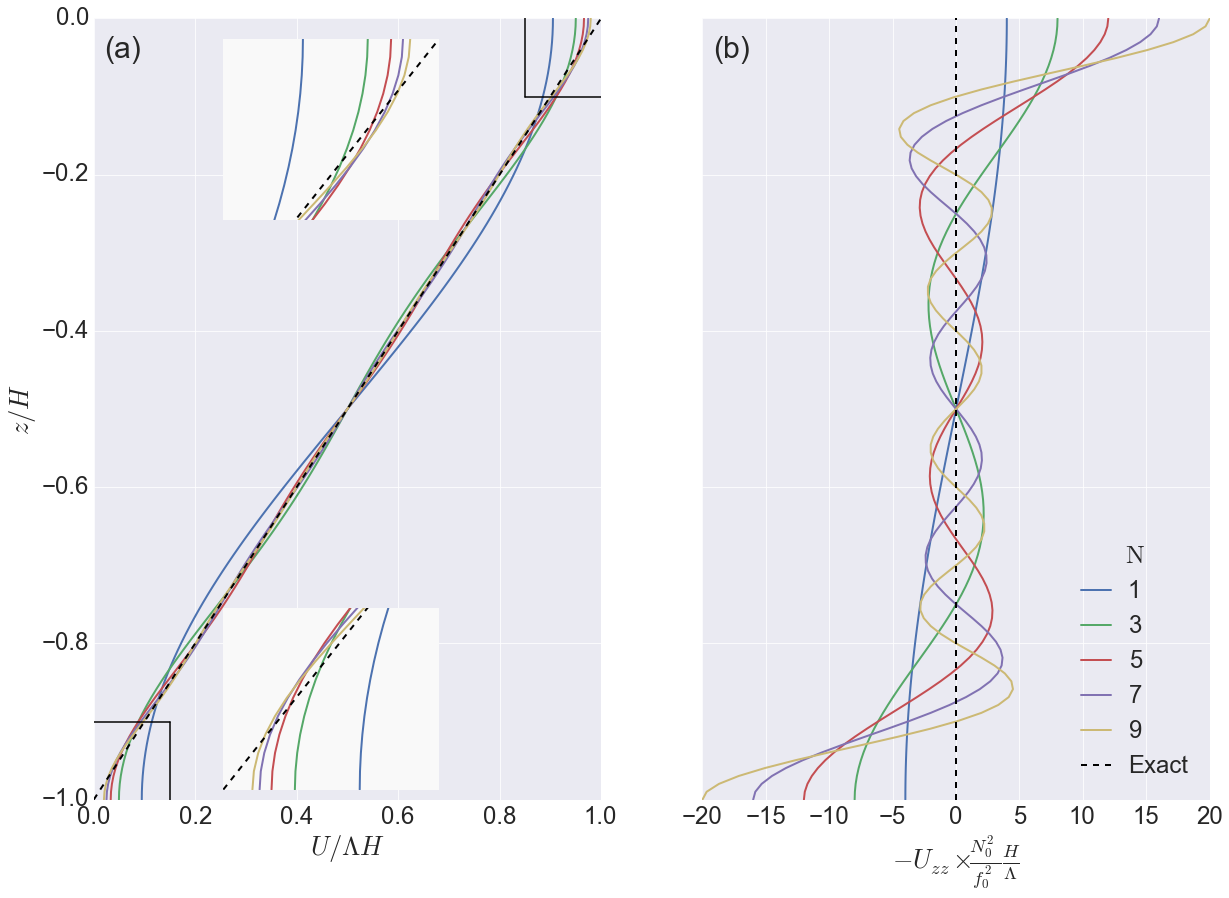

In [4]:
## velocity and PV gradient 
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True,figsize=(20,14))

for i in range(N.size):
    ax1.plot(U_g[:,i],z,label=str(N[i]),linewidth=2.) 
    ax2.plot(Qy_g[:,i],z,label=str(N[i]),linewidth=2.)    


ax1.plot(U_exact,z,'--',color='k',linewidth=2.,label='Exact')
ax1.set_xlabel(r'$U/\Lambda H$')
ax1.set_ylabel(r'$z/H$')
ax1.text(.025,-.05, '(a)', size=30, rotation=0.)

## PV gradient
ax2.set_xlabel(r'$-U_{zz} \times \frac{N_0^2}{f_0^2}\frac{H}{\Lambda}$')
ax2.plot(U_exact*0,z,'--',color='k',linewidth=2.,label='Exact')
ax2.legend(loc=4,title= r'$\mathrm{N}$')
ax2.text(-19,-.05,'(b)', size=30, rotation=0.)

## inset

# mark inset region in bigger axis
ax1.plot([.85,1.],[-.1,-.1],'-',color="k")
ax1.plot([.85,.85],[-.1,0.],'-',color="k")
ax1.plot([.0,.15],[-.9,-.9],'-',color="k")
ax1.plot([.15,.15],[-.9,-1.],'-',color="k")

# inset
def inset_vel(xl,xr,yl,yu,xil,xir,yiu,yil):
    inset = plt.axes([xil,xir,yiu,yil], axisbg='.975')
    for i in range(N.size):
        plt.plot(U_g[:,i],z,linewidth=2.)        
    plt.plot(U_exact,z,'--',color='k',linewidth=2.)
    plt.ylim(yl,yu) 
    plt.xlim(xl,xr)
    plt.setp(inset, xticks=[], yticks=[])

inset_vel(.85,1.0,-.1,0.,.215,.7,.15,.18)
inset_vel(0.,.15,-1.,-.9,.215,.135,.15,.18)

plt.savefig('figs/U_Qy_exact_galerk.eps')

## Linear stability analysis for Eady problem

Divide and conquer: First we code a couple of simple functions that will be called many times. Most of the functions have similar names/variables to the variables described in Rocha, Young, and Grooms

In [12]:
import numba

def cn(kappa,n):
    ''' n-th mode non-dimensional
        Rossby wave phase speed '''
    return -1./(kappa**2 + (n*pi)**2)

# nopython=True means an error will be raised
# if fast compilation is not possible.
def sigma12(kappa,Nmax):
    ''' evaluate sigma1 and sigma2
        sums for used in methods B and C 
        Nmax is the number of baroclinic modes '''
    
    i = np.arange(Nmax+1)
    c = cn(kappa,i)
    sigma1 = c[0] + 2.*c[1:].sum()        
    sigma2 = c[0] + 2.*(( (-1.)**i[1:] )*c[1:]).sum()
    
    return sigma1,sigma2

@numba.jit(nopython=True)
def UGpm(Nmax):
    ''' evaluate series for base velocity
        at the boundaries 
        Nmax is the number of baroclinic modes'''

    up,um = .5,.5
    for i in range(1,Nmax+1,2):
        up +=  4./( (i*pi)**2 )
        um += -4./( (i*pi)**2 )

    return up,um

@numba.jit(nopython=True)
def Xi(k,m,n):
    ''' the interaction coefficient 
        Xi for constant stratification '''

    if  ((k==0) and (m==n)): x = 1.
    elif ((m==0) and (k==n)): x = 1.
    elif ((n==0) and (k==m)): x = 1.    
    elif ((k == m+n) or (k == m-n) or (k == n-m)): 
        x = sqrt(2)/2.
    else: x = 0.

    return x

The linear stability analysis reduces to a simple eigenvalue problem in the form

\begin{equation}
\mathsf{M} \, \phi = c \phi\, ,
\end{equation}
where the matrix $\mathsf{M}$ varies from approximation to approximation. In the Eady problem, the matrix $\mathsf{M}$ is $(\mathrm{N}+1)\times(\mathrm{N}+1)$, wheres it is $2\times 2$ in approximations B (exact in this case) and C. Thus, for the Eady problem, we only need to compute the eigenvalues numerically in approximation A. First, we create a function to assemble the matrix $\mathsf{M}$ given the number of baroclinic modes $\mathrm{N}$ and the wavenumber $\kappa$. See Appendix C.



In [13]:
from numpy import cos,sin,pi,sqrt
import scipy as sp
try:
    np.use_fastnumpy = True
except:
    pass
    
import scipy.linalg
import line_profiler

def stability_matrix(kappa,Nmax):
    ''' Linear stability matrix for
        Eady Problem using method A

         ---------------------------------------   
            M phi = c phi, where c
            are the eigenvalues and phi
            the eigenvector         
            
            M is a Nmax+1 by Nmax+1 matrix
            
            Nmax is the number of baroclinic modes
                for the solution
         --------------------------------------  '''


    M1 = np.zeros((Nmax+1,Nmax+1))  
    M2 = np.zeros((Nmax+1,Nmax+1))

    # loop over rows 
    for k in range(Nmax+1):
    
        # M1 
        for m in range(Nmax+1):
            for n in range(1,Nmax+1,2):
                gamma = -2.*sqrt(2)/( kappa**2 + (m*pi)**2 )    
                M1[k,m] += Xi(k,n,m)*gamma

        # M2
        for n in range(Nmax+1):
            for m in np.append(0,range(1,Nmax+1,2)):
                if m == 0:
                    U = 1/2.
                else:    
                    U = 2.*sqrt(2)/( (m*pi)**2 )
                M2[k,n] += Xi(k,n,m)*U

    M = M1 + M2

    return M

Testing efficient of the code

In [8]:
%reload_ext line_profiler

In [14]:
%lprun -s -f stability_matrix -T lp_results.txt stability_matrix(kappa=2.,Nmax=128)


*** Profile printout saved to text file u'lp_results.txt'. 


We then create a simple function to perform the stability analysis, using either method A or C. For method A it calls **stability_matrix**. 

In [16]:
def stability_analysis(kappa,Nmax,method='C'):
    '''
     Compute the growth rate of the linear
     stability analysis for the Eady problem 

    --------------------------------------------   
        kappa is the array of wavenumbers
        Nmax is the number of baroclinic modes
            for the solution 
    ------------------------------------------------   

    '''
    
    try:
        Nkappa = kappa.size
        c = np.zeros(Nkappa,dtype='complex128')
        sig = np.zeros(Nkappa)

        if method == 'C':
   
            for i in range(Nkappa):
                sig1,sig2 = sigma12(kappa[i],Nmax)
                up,um = UGpm(Nmax)
                uh = (up+um)/2.
                D =  uh**2  - up*um +\
                        sig1*(up-um) + sig1**2 - sig2**2
                if D<0: cm = uh + 1j*np.sqrt(-D)
                else: cm = uh + np.sqrt(D)              
                c[i],sig[i] = cm,kappa[i]*cm.imag

        elif method == 'A':
            for i in range(Nkappa):
                M = stability_matrix(kappa[i],Nmax)
                cm = np.linalg.eigvals(M)
                imax = cm.imag.argmax()
                c[i],sig[i] = cm[imax],kappa[i]*cm.imag[imax]

    except AttributeError:
        
        if method == 'C':
            sig1,sig2 = sigma12(kappa,Nmax)
            up,um = UGpm(Nmax)
            uh = (up+um)/2.

            D =  uh**2  - up*um +\
                    sig1*(up-um) + sig1**2 - sig2**2

            if D<0: cm = uh + 1j*np.sqrt(-D)
            else: cm = uh + np.sqrt(D)

            c,sig = cm,kappa*cm.imag

        elif method == 'A':   
            M = stability_matrix(kappa,Nmax)
            cm = np.linalg.eigvals(M)
            imax = cm.imag.argmax()
            c,sig = cm[imax],kappa*cm.imag[imax]

    return c,sig

We now loop compute the eigenvalue for different wanumber $\kappa$ over an array of number of baroclinic modes $\mathrm{N}$ to study the converge of different approximations. (It may take a while to run for a large number of baroclinic modes using approximation A.)

In [17]:
kappa = np.linspace(0.001,10.,100)

Nmodes = np.arange(0,25)
Nmodes = np.append(Nmodes,2**np.arange(5,8))

c_galerkA,sig_galerkA = np.zeros((Nmodes.size,kappa.size),\
            dtype='complex128'),np.zeros((Nmodes.size,kappa.size))
c_galerkC,sig_galerkC = np.zeros((Nmodes.size,kappa.size),\
            dtype='complex128'),np.zeros((Nmodes.size,kappa.size))

# solve the linear problem
for i in range(Nmodes.size):
    
    c_galerkC[i,:],sig_galerkC[i,:] = stability_analysis(kappa,\
            Nmodes[i],method='C')
    
    # if Nmodes = 0, A is stable
    if Nmodes[i] == 0:
        c_galerkA[i,:],sig_galerkA[i,:] = 0.,0.5
    else:    
        c_galerkA[i,:],sig_galerkA[i,:] = stability_analysis(kappa,\
                Nmodes[i],method='A')

It's useful to save the files so that we can plot, compare, and perform other analysis in a different notebook

In [18]:
np.savez('outputs/eady_A.npz',c=c_galerkA,sig=sig_galerkA,\
         kappa=kappa,Nmodes=Nmodes)
np.savez('outputs/eady_C.npz',c=c_galerkC,sig=sig_galerkC,\
         kappa=kappa,Nmodes=Nmodes)

Method B is exact.

In [26]:
kappa_2 = kappa/2. + 0j
c_exact = .5 + np.sqrt( (kappa_2 - np.tanh(kappa_2))\
        *(kappa_2 - 1./np.tanh(kappa_2)) )/kappa
sig_exact = kappa*c_exact.imag

np.savez('outputs/eady_exact.npz',c=c_exact,sig=sig_exact,\
         kappa=kappa)

Now we plot the results to study the convergence of different approximations. 

In [20]:
import seaborn as sns
sns.set(style="darkgrid")
sns.set_context("paper", font_scale=3., rc={"lines.linewidth": 1.5})
sns.set_style("darkgrid",{'grid_color':.95})

In [21]:
def labels(field='sig',fs=25):
    ''' set labels  in figures '''
    plt.xlabel(r'$\kappa \times\, L_d$',fontsize=fs)
    if field == 'sig':    
        plt.ylabel(r'$\sigma \times \, \frac{\Lambda H}{L}$',fontsize=fs)
    elif field == 'ps':
        plt.ylabel(r'$c_r / \Lambda H$',fontsize=fs)

def plt_exact(field='sig'):
    ''' plot the exact solution '''
    if field == 'sig':
        plt.plot(eady_exact['kappa'],eady_exact['sig'],color="k",\
                linewidth=4.,label='B, Exact')
    elif field == 'ps':
        plt.plot(eady_exact['kappa'],eady_exact['c'].real,color="k",\
                linewidth=4.,label='B, Exact')

In [22]:
path = 'outputs/'
eadyA = np.load(path+'eady_A.npz')
eadyC = np.load(path+'eady_C.npz')
eady_exact = np.load(path+'eady_exact.npz')

Nmodes = eadyA['Nmodes']

In [23]:
lw,aph = 4.,.75
color1,color2 = "#1e90ff","#ff6347"

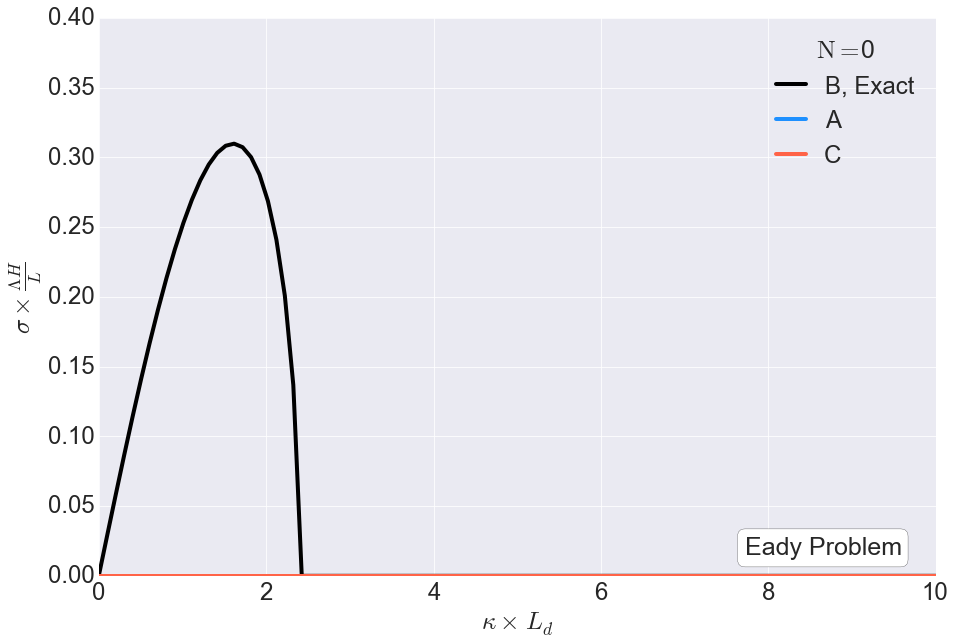

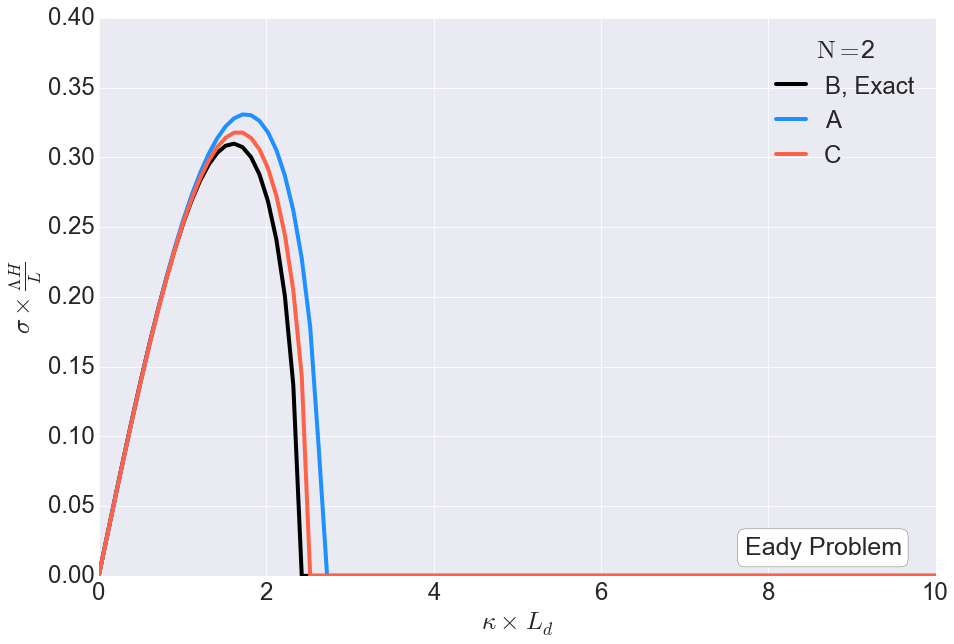

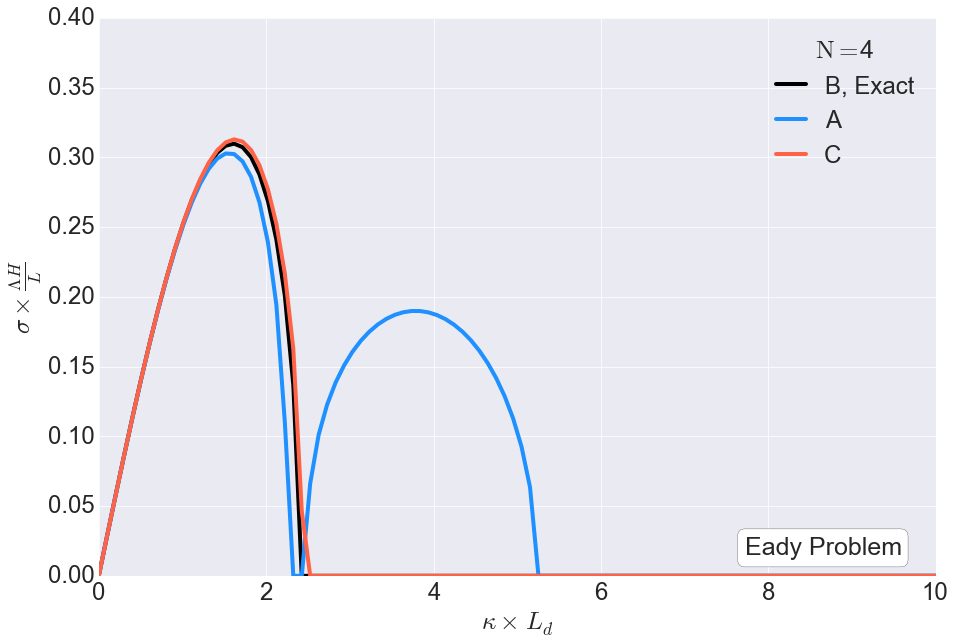

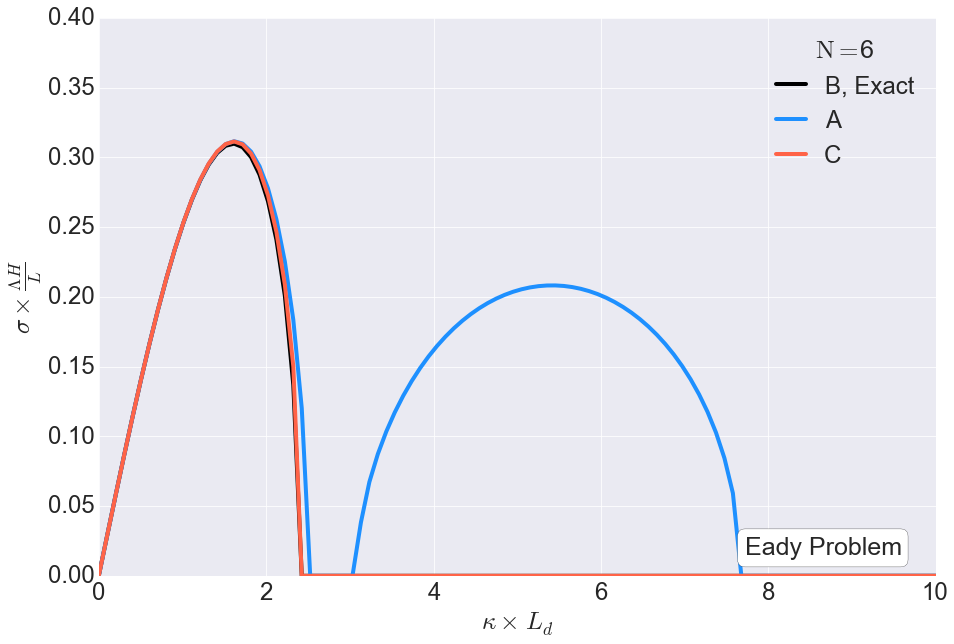

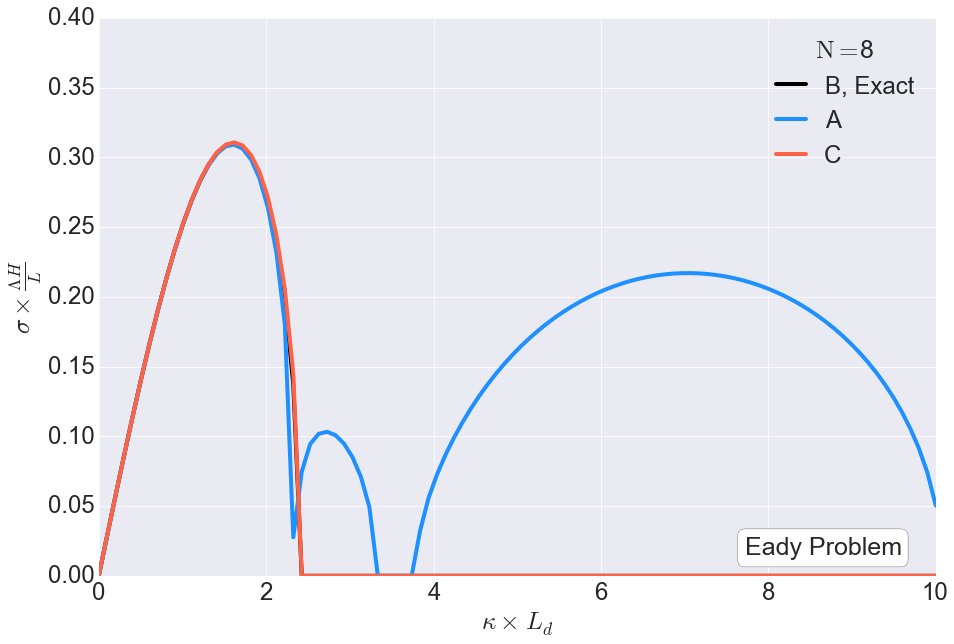

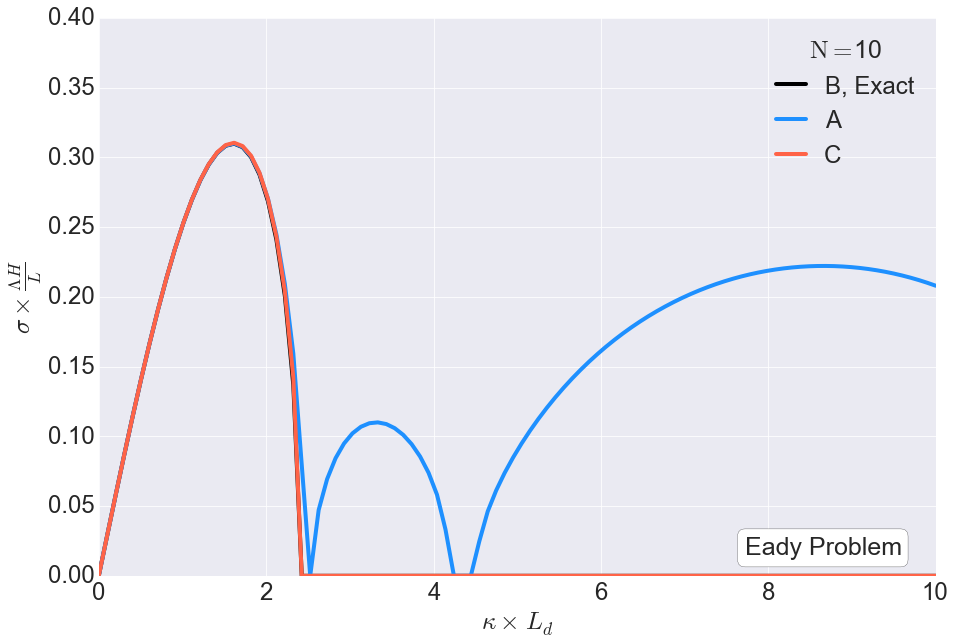

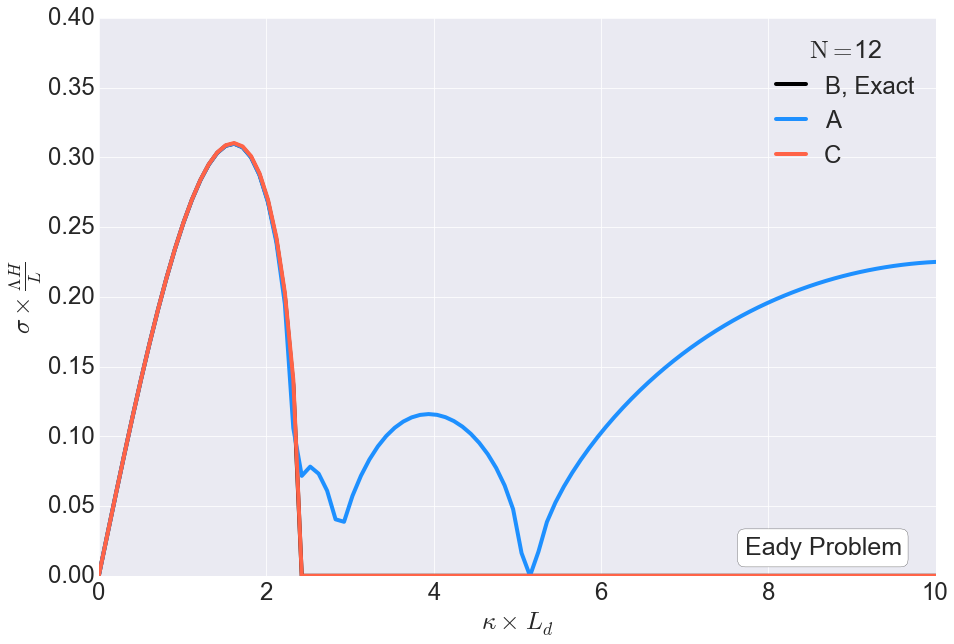

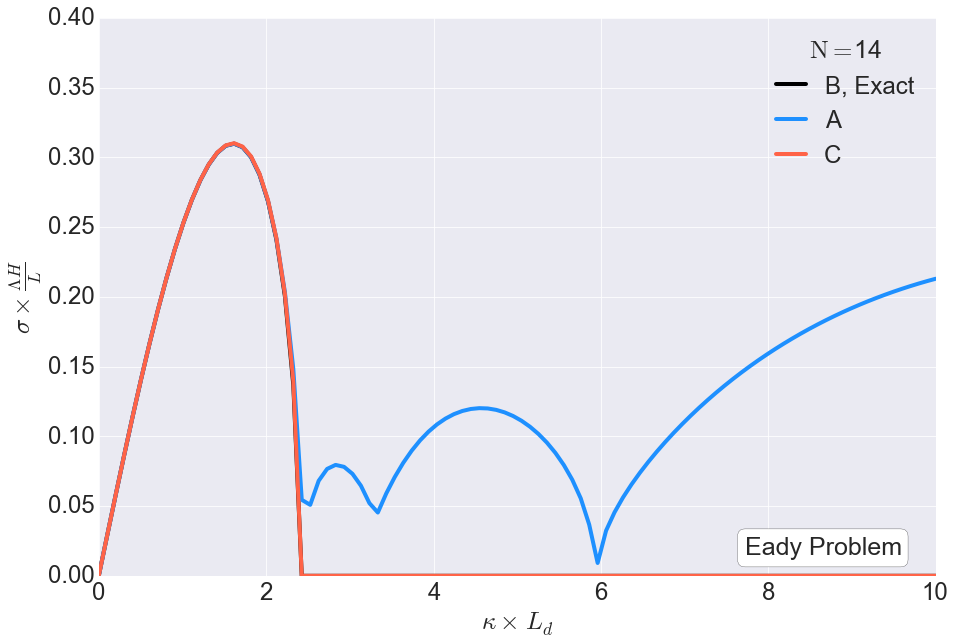

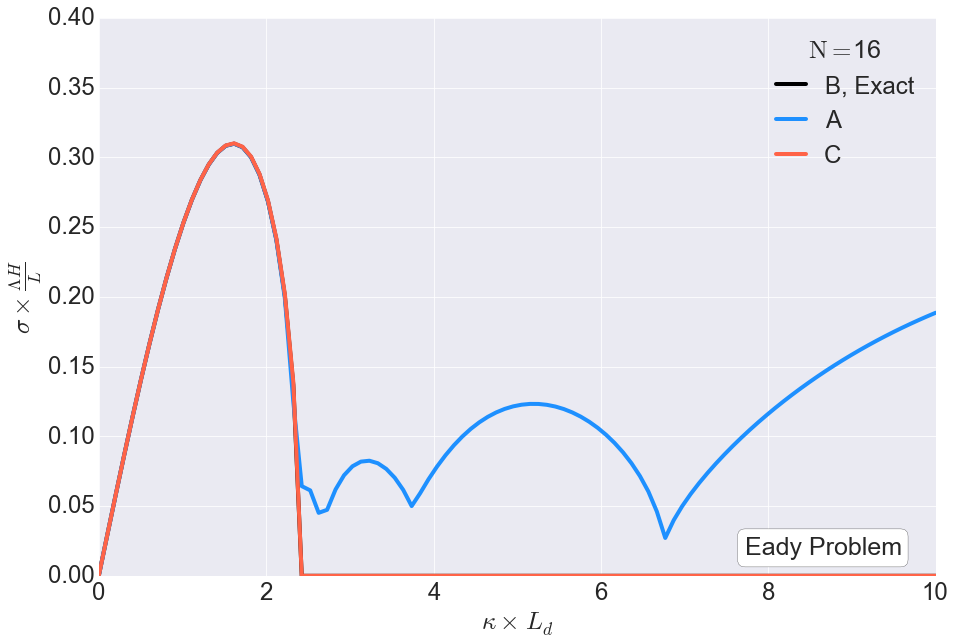

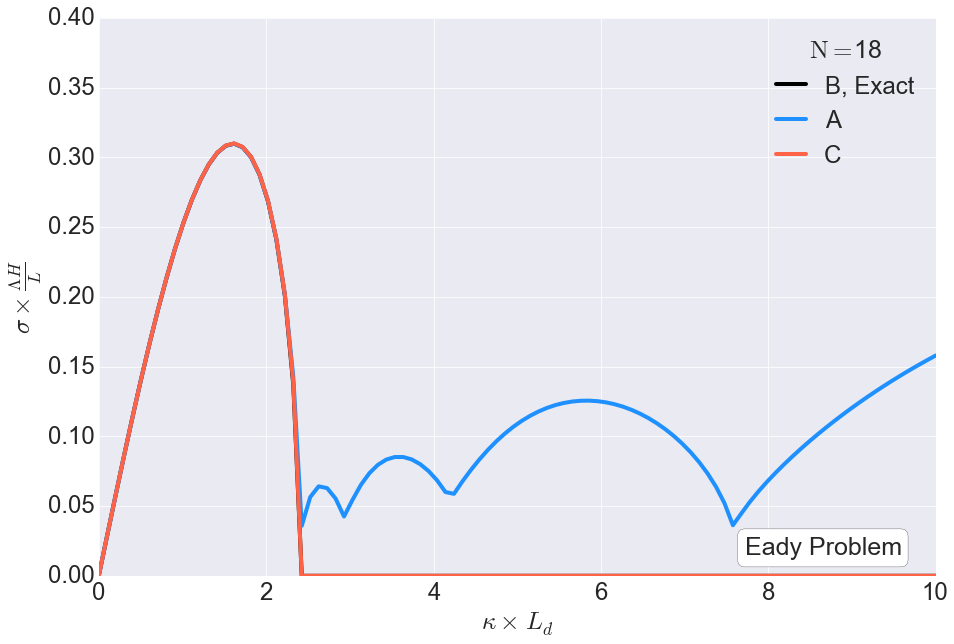

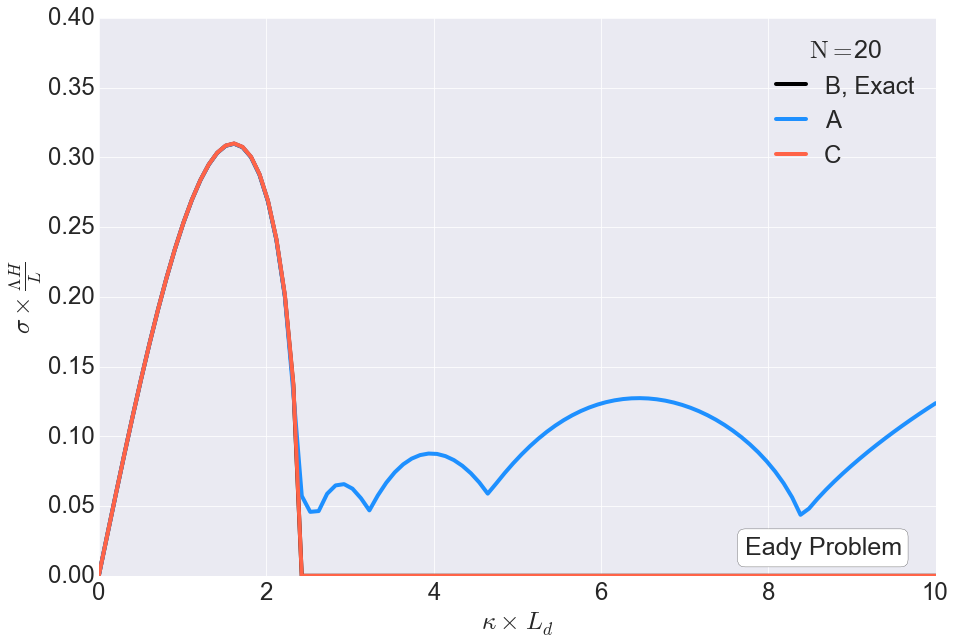

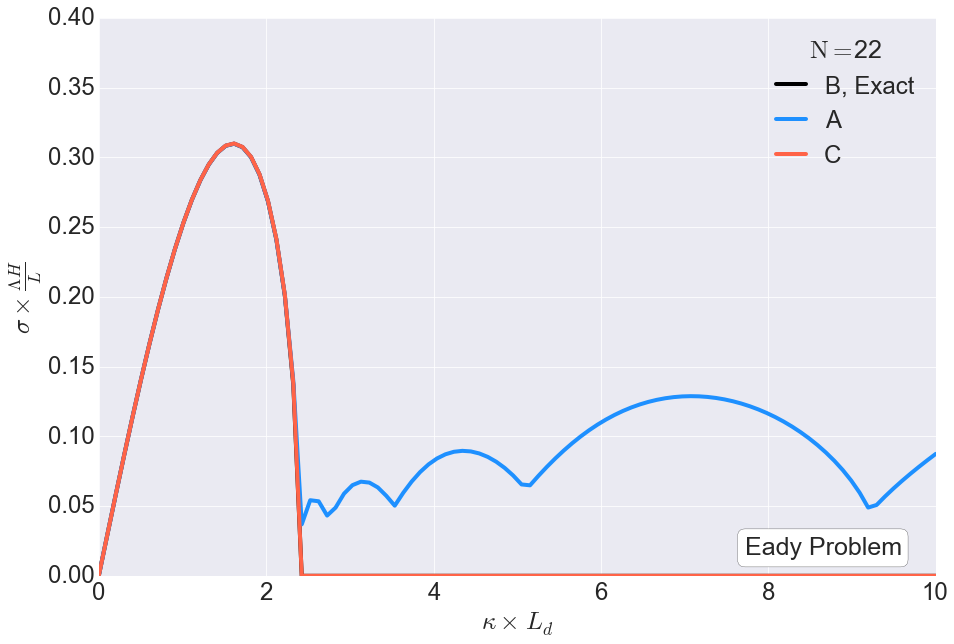

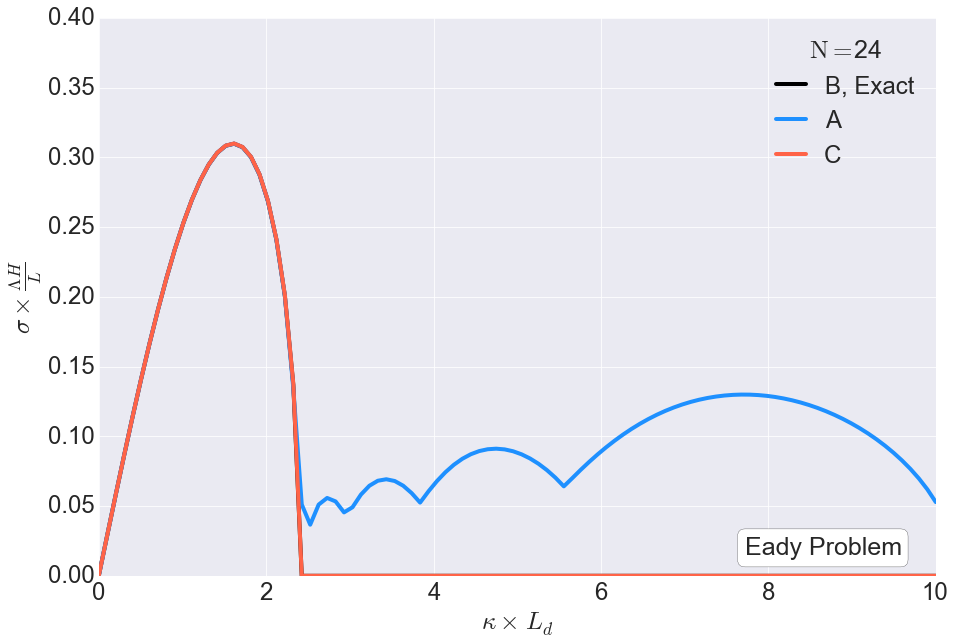

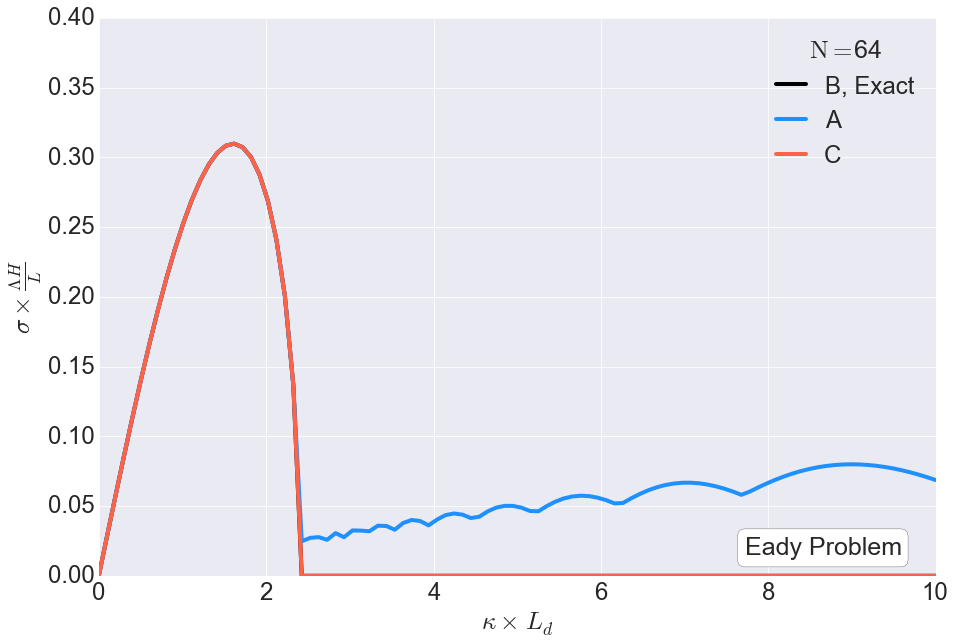

In [31]:
for i in range(Nmodes.size):
    fig=plt.figure(figsize=(15,10))
    plt_exact('sig')
    plt.plot(eadyA['kappa'],eadyA['sig'][i,:],\
            color=color1,linewidth=lw,label='A')
    plt.plot(eadyC['kappa'],eadyC['sig'][i,:],\
            color=color2,linewidth=lw,label='C')

    labels() 
    plt.legend(loc=1, title = r'$\mathrm{N} = $' + str(Nmodes[i]))
    plt.ylim(0.,0.4)
    plt.text(8.65, .02, "Eady Problem", size=25, rotation=0.,\
            ha="center", va="center",\
            bbox = dict(boxstyle="round",ec='k',fc='w'))

    figtit = 'figs/eady_sig_galerk_ABC_'+str(Nmodes[i])+'.eps'
    plt.savefig(figtit,format='eps') 
    
    # close some of the figures
    if i%2:
        plt.close()


We may also be interested in computing the relative error, e.g. at the most unstable mode

In [28]:
def relative_error(exact,approx):
    ''' compute relative error '''
    return np.abs(exact-approx)/np.abs(exact)

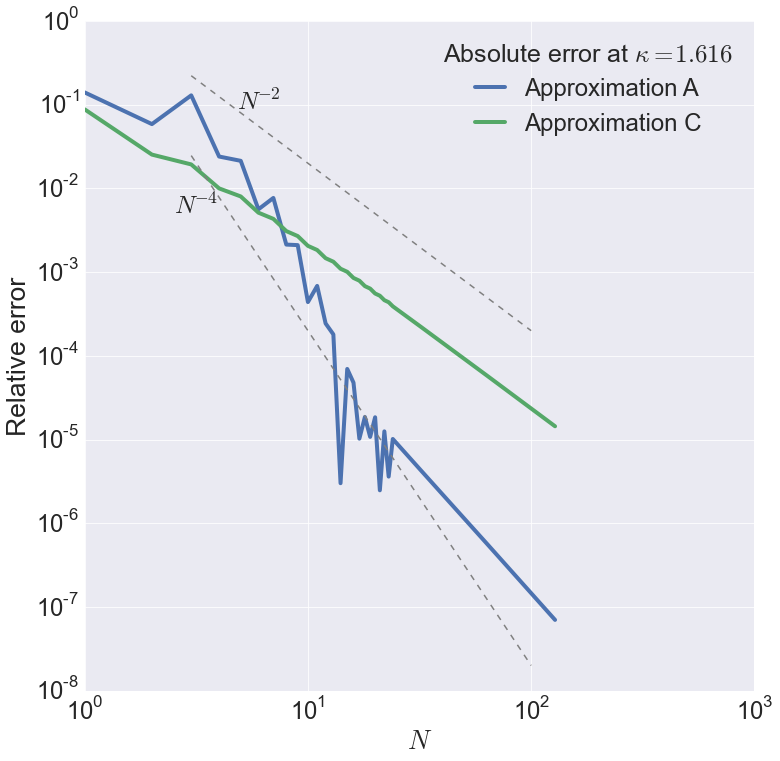

In [29]:
# error estimates
imax = eady_exact['sig'].argmax()   # maximum sig in exact sol
error_sig_maxA, error_sig_maxC = np.zeros(Nmodes.size),\
    np.zeros(Nmodes.size)

for i in range(Nmodes.size):
    error_sig_maxA[i] = relative_error(eady_exact['sig'][imax],\
            eadyA['sig'][i,imax])
    error_sig_maxC[i] = relative_error(eady_exact['sig'][imax],\
            eadyC['sig'][i,imax])

## plot error fixed k
ns = np.array([3.,100.])
es2,es4 = 1/(ns**2), 1/(ns**4)

fig=plt.figure(figsize=(12,12))
plt.loglog(Nmodes,error_sig_maxA,linewidth=lw,label='Approximation A')
plt.loglog(Nmodes,error_sig_maxC,linewidth=lw,label='Approximation C')
plt.loglog(ns,2*es2,'--',color=".5")
plt.loglog(ns,2*es4,'--',color=".5")
plt.text(4.800, 0.087,r'$N^{-2}$',fontsize=25)
plt.text(2.5, 0.005,r'$N^{-4}$',fontsize=25)
plt.xlabel(r'$N$')
plt.ylabel(r'Relative error')
plt.legend(loc=1, title = r'Absolute error at $\kappa = 1.616$')
plt.savefig('figs/relative_error_ABC_fixed_k')